In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [2]:
#set FIXED variables
HOMEPATH = "/home/ubuntu/fastai/"

import os, errno
from datetime import datetime
import unidecode

nb: need to install packages as below for standard aws ubuntu deep learning community AMI   
sudo -H pip install unidecode
sudo -H pip install bcolz  
sudo -H pip install toolz  

nb: original utils.py from https://github.com/fastai/courses.git needs fix.
update to utils.py as per https://github.com/fastai/courses/issues/146 required.

In [3]:
GIT_REPO_PATH = "/home/ubuntu/courses/deeplearning1/nbs"

In [4]:
os.chdir(GIT_REPO_PATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('current working directory:', '/home/ubuntu/courses/deeplearning1/nbs')


Using TensorFlow backend.


wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip  
wget http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [7]:
path = "/home/ubuntu/fastai/data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

userId,movieId,rating,timestamp  
1,31,2.5,1260759144  
1,1029,3.0,1260759179  
1,1061,3.0,1260759182  
1,1129,2.0,1260759185  


In [8]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()
#refer lesson 6 @ 6'57"

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

movieId,title,genres  
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy  
2,Jumanji (1995),Adventure|Children|Fantasy  
3,Grumpier Old Men (1995),Comedy|Romance  
4,Waiting to Exhale (1995),Comedy|Drama|Romance  


In [10]:
movie_names = pd.read_csv(path+'movies.csv', encoding = 'utf8').set_index('movieId')['title']#.to_dict()

In [12]:
tempdf = pd.DataFrame.from_csv(path+'movies.csv')
type(tempdf), tempdf.shape, list(tempdf)
temp = tempdf.groupby('title')['genres'].nunique()
print (len(temp))
print (temp[0:5])

9123
title
"Great Performances" Cats (1998)           1
$9.99 (2008)                               1
'Hellboy': The Seeds of Creation (2004)    1
'Neath the Arizona Skies (1934)            1
'Round Midnight (1986)                     1
Name: genres, dtype: int64


In [13]:
print (type(movie_names), movie_names.shape)  
print (movie_names.head(5))

<class 'pandas.core.series.Series'> (9125,)
movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object


In [14]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [15]:
print ("users:", type(users), users.shape)
print ("movies:", type(movies), movies.shape)

users: <type 'numpy.ndarray'> (671,)
movies: <type 'numpy.ndarray'> (9066,)


In [16]:
print ("users:", users[0:5])
print ("movies:", movies[0:5])

users: [1 2 3 4 5]
movies: [  31 1029 1061 1129 1172]


In [17]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
print(type(userid2idx), len(userid2idx))
print(type(movieid2idx), len(movieid2idx))


<type 'dict'> 671
<type 'dict'> 9066


In [18]:
print (next(iter(userid2idx)))
print (next(iter(userid2idx)))

print ("userid2idx.keys()[0:5] (ratings.csv).userId.unique():", userid2idx.keys()[0:5], type(userid2idx.keys()[0]))
print ("movieid2idx.keys()[0:5] (ratings.csv).movieId.unique():", movieid2idx.keys()[0:5], type(movieid2idx.keys()[0]))
print (userid2idx[2], list(users.flatten()).count(2))
print ("movieid2idx[2]:", movieid2idx[2], list(movies.flatten()).count(2))
print ("movieid2idx[3]:", movieid2idx[3], list(movies.flatten()).count(3))

1
1
userid2idx.keys()[0:5] (ratings.csv).userId.unique(): [1, 2, 3, 4, 5] <type 'numpy.int64'>
movieid2idx.keys()[0:5] (ratings.csv).movieId.unique(): [1, 2, 3, 4, 5] <type 'numpy.int64'>
1 1
movieid2idx[2]: 650 1
movieid2idx[3]: 319 1


We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [19]:
print (type(ratings.movieId))
print (movieid2idx[1])

<class 'pandas.core.series.Series'>
417


In [20]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [21]:
type(ratings)

pandas.core.frame.DataFrame

In [22]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
print (user_min, user_max, movie_min, movie_max)

0 670 0 9065


In [23]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.nunique.html
#Return number of unique elements in the object.

print (type(ratings.userId))
print (type(ratings.movieId))
n_users, n_movies

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


(671, 9066)

This is the number of latent factors in each embedding.

In [24]:
n_factors = 50

In [25]:
np.random.seed = 42

Randomly split into training and validation.

In [26]:
print ("len(ratings):", len(ratings))
msk = np.random.rand(len(ratings)) < 0.8
print ("msk:", type(msk), msk.shape)
#creates numpy array of True or False values with probably 80% true
print (type(msk), msk[0])
trn = ratings[msk]
val = ratings[~msk]

len(ratings): 100004
msk: <type 'numpy.ndarray'> (100004,)
<type 'numpy.ndarray'> False


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [27]:
print (ratings.shape)
print (ratings[0:4])

g=ratings.groupby('userId')['rating'].count()
#group by 'userId', 'rating', count rows

print (type(g), g.shape)
print (g[0:4])
print (g.sort_values(ascending=False)[0:5])
topUsers=g.sort_values(ascending=False)[:15]
#select top 15 users.

(100004, 4)
   userId  movieId  rating   timestamp
0       0        0     2.5  1260759144
1       0        1     3.0  1260759179
2       0        2     3.0  1260759182
3       0        3     2.0  1260759185
<class 'pandas.core.series.Series'> (671,)
userId
0     20
1     76
2     51
3    204
Name: rating, dtype: int64
userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64


In [28]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [29]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [30]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [31]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [79]:
n_users, n_factors

(671, 50)

In [32]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  after removing the cwd from sys.path.


In [78]:
type(user_in), type(u), type(movie_in), type(m)

(tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor)

In [75]:
x = merge([u, m], mode='dot')
#https://keras.io/layers/merge/#dot_1
#possibly this change.
#needs axes: Integer or tuple of integers, axis or axes along which to take the dot product.
#x = keras.layers.dot([u, m])
x = Flatten()(x)
model = Model([user_in, movie_in], x)
#https://keras.io/models/model/

model.compile(Adam(0.001), loss='mse')
print (type(model))

<class 'keras.engine.training.Model'>


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.


In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))
#github gets loss: 9.8328 - val_loss: 3.7591 cf loss: 9.9450 - val_loss: 4.3126

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 79978 samples, validate on 20026 samples
Epoch 1/1
79978/79978 [==============================] - 6s - loss: 9.9079 - val_loss: 4.2210


In [ ]:
model.optimizer.lr=0.01

In [35]:
print ("start")
startTime= datetime.now()
history = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Train on 79978 samples, validate on 20026 samples
Epoch 1/3
 2752/79978 [>.............................] - ETA: 4s - loss: 3.8929

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


79978/79978 [==============================] - 5s - loss: 3.1413 - val_loss: 2.7649
Epoch 2/3
79978/79978 [==============================] - 5s - loss: 2.4212 - val_loss: 2.5649
Epoch 3/3
79978/79978 [==============================] - 5s - loss: 2.2544 - val_loss: 2.5243
Time elapsed (hh:mm:ss.ms) 0:00:15.217588


In [36]:
model.optimizer.lr=0.001

In [37]:
print ("start")
startTime= datetime.now()
history2 = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#github = loss: 2.0673 - val_loss: 1.4457 vs loss: 2.0542 - val_loss: 2.5753
#nb: loss is reducing, val_loss is not. loss is much less than val_loss overtraining?

start
Train on 79978 samples, validate on 20026 samples
Epoch 1/6
 2752/79978 [>.............................] - ETA: 4s - loss: 2.1025

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


79978/79978 [==============================] - 5s - loss: 2.1901 - val_loss: 2.5124
Epoch 2/6
79978/79978 [==============================] - 5s - loss: 2.1552 - val_loss: 2.5106
Epoch 3/6
79978/79978 [==============================] - 5s - loss: 2.1296 - val_loss: 2.5139
Epoch 4/6
79978/79978 [==============================] - 5s - loss: 2.1071 - val_loss: 2.5173
Epoch 5/6
79978/79978 [==============================] - 5s - loss: 2.0843 - val_loss: 2.5252
Epoch 6/6
79978/79978 [==============================] - 5s - loss: 2.0630 - val_loss: 2.5273
Time elapsed (hh:mm:ss.ms) 0:00:30.465694


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [38]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)
#refer lesson 5 video @ 14'40"
#also lesson 6 video @ 31'14" ?

In [82]:
print ("n_users:", n_users, ", n_factors:", n_factors)
print ("n_movies:", n_movies, ", n_factors:", n_factors)

n_users: 671 , n_factors: 50
n_movies: 9066 , n_factors: 50


In [83]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
print ("type(user_in):\t", type(user_in))
print ("type(u):\t", type(u))
print ("type(movie_in):\t", type(movie_in))
print ("type(m):\t", type(m))

type(user_in):	 <class 'tensorflow.python.framework.ops.Tensor'>
type(u):	 <class 'tensorflow.python.framework.ops.Tensor'>
type(movie_in):	 <class 'tensorflow.python.framework.ops.Tensor'>
type(m):	 <class 'tensorflow.python.framework.ops.Tensor'>


In [88]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [89]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

refer video lesson 5 @ 27"08'"

In [42]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.


In [43]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 79978 samples, validate on 20026 samples
Epoch 1/1
79978/79978 [==============================] - 6s - loss: 8.7117 - val_loss: 3.4316


In [ ]:
model.optimizer.lr=0.01

In [44]:
history3 = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=20, 
          validation_data=([val.userId, val.movieId], val.rating))
#github result = loss: 0.5747 - val_loss: 0.7979 vs my result after 6 epochs loss: 1.5886 - val_loss: 1.7878
#very bad result by comparison.
#after 20 epochs,  loss: 0.6405 - val_loss: 1.0564 both losses are consistently reducing. 
#loss is << val_loss so overfitting

Train on 79978 samples, validate on 20026 samples
Epoch 1/20
 2176/79978 [..............................] - ETA: 5s - loss: 3.3345

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


79978/79978 [==============================] - 6s - loss: 2.5843 - val_loss: 2.2702
Epoch 2/20
79978/79978 [==============================] - 6s - loss: 2.0076 - val_loss: 2.0865
Epoch 3/20
79978/79978 [==============================] - 6s - loss: 1.8488 - val_loss: 1.9950
Epoch 4/20
79978/79978 [==============================] - 6s - loss: 1.7532 - val_loss: 1.9193
Epoch 5/20
79978/79978 [==============================] - 6s - loss: 1.6740 - val_loss: 1.8505
Epoch 6/20
79978/79978 [==============================] - 6s - loss: 1.5993 - val_loss: 1.7858
Epoch 7/20
79978/79978 [==============================] - 6s - loss: 1.5280 - val_loss: 1.7234
Epoch 8/20
79978/79978 [==============================] - 6s - loss: 1.4570 - val_loss: 1.6637
Epoch 9/20
79978/79978 [==============================] - 6s - loss: 1.3879 - val_loss: 1.6043
Epoch 10/20
79978/79978 [==============================] - 6s - loss: 1.3192 - val_loss: 1.5537
Epoch 11/20
79978/79978 [==============================] - 6

In [ ]:
model.optimizer.lr=0.001

In [45]:
startTime= datetime.now()
print ("startTime:", startTime)
history4 = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=20, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#ran with 10 epochs then again with 20 epochs

startTime: 2018-01-14 23:09:26.964117
Train on 79978 samples, validate on 20026 samples
Epoch 1/20
79978/79978 [==============================] - 6s - loss: 0.7711 - val_loss: 1.1401
Epoch 2/20
79978/79978 [==============================] - 6s - loss: 0.7399 - val_loss: 1.1184
Epoch 3/20
79978/79978 [==============================] - 6s - loss: 0.7117 - val_loss: 1.0992
Epoch 4/20
79978/79978 [==============================] - 6s - loss: 0.6859 - val_loss: 1.0815
Epoch 5/20
79978/79978 [==============================] - 6s - loss: 0.6634 - val_loss: 1.0669
Epoch 6/20
79978/79978 [==============================] - 6s - loss: 0.6434 - val_loss: 1.0538
Epoch 7/20
79978/79978 [==============================] - 6s - loss: 0.6258 - val_loss: 1.0433
Epoch 8/20
79978/79978 [==============================] - 6s - loss: 0.6105 - val_loss: 1.0345
Epoch 9/20
79978/79978 [==============================] - 6s - loss: 0.5974 - val_loss: 1.0272
Epoch 10/20
79978/79978 [==============================] 

In [46]:
startTime= datetime.now()
print ("startTime:", startTime)
history5 = model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=20, 
          validation_data=([val.userId, val.movieId], val.rating))
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: video lecture val_loss is down to 0.7979 = refer lesson 5 @ 15"07'
#github results : loss: 0.5747 - val_loss: 0.7979
#ran w 5 epochs, loss is stabilising around 0.523 val_loss stabilising around 1.03
#quite different margins to the examples in github and video.

startTime: 2018-01-14 23:11:27.615962
Train on 79978 samples, validate on 20026 samples
Epoch 1/20
79978/79978 [==============================] - 6s - loss: 0.5389 - val_loss: 1.0110
Epoch 2/20
79978/79978 [==============================] - 6s - loss: 0.5376 - val_loss: 1.0119
Epoch 3/20
79978/79978 [==============================] - 6s - loss: 0.5360 - val_loss: 1.0126
Epoch 4/20
79978/79978 [==============================] - 6s - loss: 0.5350 - val_loss: 1.0133
Epoch 5/20
79978/79978 [==============================] - 6s - loss: 0.5338 - val_loss: 1.0137
Epoch 6/20
79978/79978 [==============================] - 6s - loss: 0.5328 - val_loss: 1.0147
Epoch 7/20
79978/79978 [==============================] - 6s - loss: 0.5317 - val_loss: 1.0152
Epoch 8/20
79978/79978 [==============================] - 6s - loss: 0.5311 - val_loss: 1.0158
Epoch 9/20
79978/79978 [==============================] - 6s - loss: 0.5302 - val_loss: 1.0176
Epoch 10/20
79978/79978 [==============================] 

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [ ]:
#model.save_weights(model_path+'bias.h5')

In [ ]:
#model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [47]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9757]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [48]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [49]:
print (type(movie_in))
print (type(mb))
print (type(topMovies), topMovies.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<type 'numpy.ndarray'> (2000,)


In [50]:
get_movie_bias = Model(movie_in, mb)
#does a lookup in the movie bias table
#keras.models.Model
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [51]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.2772199, u'Police Academy 6: City Under Siege (1989)'),
 (-1.1417201, u'Battlefield Earth (2000)'),
 (-1.0027685, u'Jaws 3-D (1983)'),
 (-0.86897182, u'Speed 2: Cruise Control (1997)'),
 (-0.84511393, u'Super Mario Bros. (1993)'),
 (-0.76097083, u'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.74831927, u'Spice World (1997)'),
 (-0.71563792, u'Police Academy 3: Back in Training (1986)'),
 (-0.66238481, u'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.63593763, u'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.61538118, u'Nutty Professor II: The Klumps (2000)'),
 (-0.61155975, u'Bio-Dome (1996)'),
 (-0.60907519, u'Honey, I Blew Up the Kid (1992)'),
 (-0.60264713, u'Blade: Trinity (2004)'),
 (-0.57534081, u'House on Haunted Hill (1999)')]

In [52]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(2.0757475, u'Killer, The (Die xue shuang xiong) (1989)'),
 (1.9769176, u'Tom Jones (1963)'),
 (1.9536529, u'Capturing the Friedmans (2003)'),
 (1.9302889, u'It Happened One Night (1934)'),
 (1.9213145, u'Wings of Desire (Himmel \xfcber Berlin, Der) (1987)'),
 (1.8705131, u'Inherit the Wind (1960)'),
 (1.8425505, u'Big Night (1996)'),
 (1.8329078, u'Happiness (1998)'),
 (1.8275378, u'Lifeboat (1944)'),
 (1.8264905, u'Shawshank Redemption, The (1994)'),
 (1.8240407, u'Seventh Seal, The (Sjunde inseglet, Det) (1957)'),
 (1.807508, u'Cool Hand Luke (1967)'),
 (1.8051718, u'Ran (1985)'),
 (1.7984338, u'Paths of Glory (1957)'),
 (1.7913942, u'Godfather, The (1972)')]

We can now do the same thing for the embeddings.

In [53]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [55]:
fac0 = movie_pca[0]

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10491909, u'Independence Day (a.k.a. ID4) (1996)'),
 (0.094077691, u'Armageddon (1998)'),
 (0.070668347, u'Titanic (1997)'),
 (0.069992647, u'Mission: Impossible II (2000)'),
 (0.068872124, u'Stargate (1994)'),
 (0.067476608, u'Pearl Harbor (2001)'),
 (0.067302592, u'X-Men (2000)'),
 (0.067247391, u'Shrek 2 (2004)'),
 (0.066668242, u'Batman Forever (1995)'),
 (0.065124035, u"Pirates of the Caribbean: Dead Man's Chest (2006)")]

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11833423, u'Fargo (1996)'),
 (-0.11555812, u'2001: A Space Odyssey (1968)'),
 (-0.10885016, u'Pulp Fiction (1994)'),
 (-0.10580757, u'Taxi Driver (1976)'),
 (-0.083414704, u'Clockwork Orange, A (1971)'),
 (-0.082261533, u"Amelie (Fabuleux destin d'Am\xe9lie Poulain, Le) (2001)"),
 (-0.080584325,
  u'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.07677453, u'American Beauty (1999)'),
 (-0.075071856, u'Trainspotting (1996)'),
 (-0.071397908, u'Reservoir Dogs (1992)')]

In [59]:
fac1 = movie_pca[1]

In [60]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [61]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.18642278, u'Lord of the Rings: The Two Towers, The (2002)'),
 (0.15225933, u'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.14310992, u'Lord of the Rings: The Return of the King, The (2003)'),
 (0.10836317, u'Matrix, The (1999)'),
 (0.10798652, u'Star Wars: Episode IV - A New Hope (1977)'),
 (0.10704716, u'Gladiator (2000)'),
 (0.10668633,
  u'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.10336302, u'Silence of the Lambs, The (1991)'),
 (0.10309129, u'Back to the Future (1985)'),
 (0.10271803, u'Star Wars: Episode VI - Return of the Jedi (1983)')]

In [62]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.084039964, u'Life Is Beautiful (La Vita \xe8 bella) (1997)'),
 (-0.062574811, u'Slumdog Millionaire (2008)'),
 (-0.059497856, u'Room with a View, A (1986)'),
 (-0.059186153, u'Hoop Dreams (1994)'),
 (-0.058974694, u'Postman, The (Postino, Il) (1994)'),
 (-0.057143301, u'Sabrina (1995)'),
 (-0.055993121, u'Charlie and the Chocolate Factory (2005)'),
 (-0.054115392, u'Christmas Story, A (1983)'),
 (-0.051421054, u'Bringing Up Baby (1938)'),
 (-0.050097223, u'Ransom (1996)')]

In [63]:
fac2 = movie_pca[2]

In [64]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [65]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.1401501, u'Beauty and the Beast (1991)'),
 (0.12655284, u"Schindler's List (1993)"),
 (0.12467088, u'Babe (1995)'),
 (0.11423202, u'Aladdin (1992)'),
 (0.10233188, u'Shrek (2001)'),
 (0.090903409,
  u'Pirates of the Caribbean: The Curse of the Black Pearl (2003)'),
 (0.090695955, u'Apollo 13 (1995)'),
 (0.084689245, u'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.08445058, u'Toy Story 2 (1999)'),
 (0.081783719, u'Grease (1978)')]

In [66]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.096844494, u'American Psycho (2000)'),
 (-0.093116529, u'Demolition Man (1993)'),
 (-0.089347281, u'Natural Born Killers (1994)'),
 (-0.088586688, u'Eyes Wide Shut (1999)'),
 (-0.085062712, u'Stargate (1994)'),
 (-0.08111202, u'Game, The (1997)'),
 (-0.073350981, u'Happy Gilmore (1996)'),
 (-0.069650687, u'Seven (a.k.a. Se7en) (1995)'),
 (-0.068812303, u'Lost in Translation (2003)'),
 (-0.065308847, u'Heathers (1989)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [67]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr


In [68]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
print (type(X), X.shape)
print (type(Y), Y.shape)

print (type(topMovies), topMovies.shape)

<type 'numpy.ndarray'> (50,)
<type 'numpy.ndarray'> (50,)
<type 'numpy.ndarray'> (2000,)


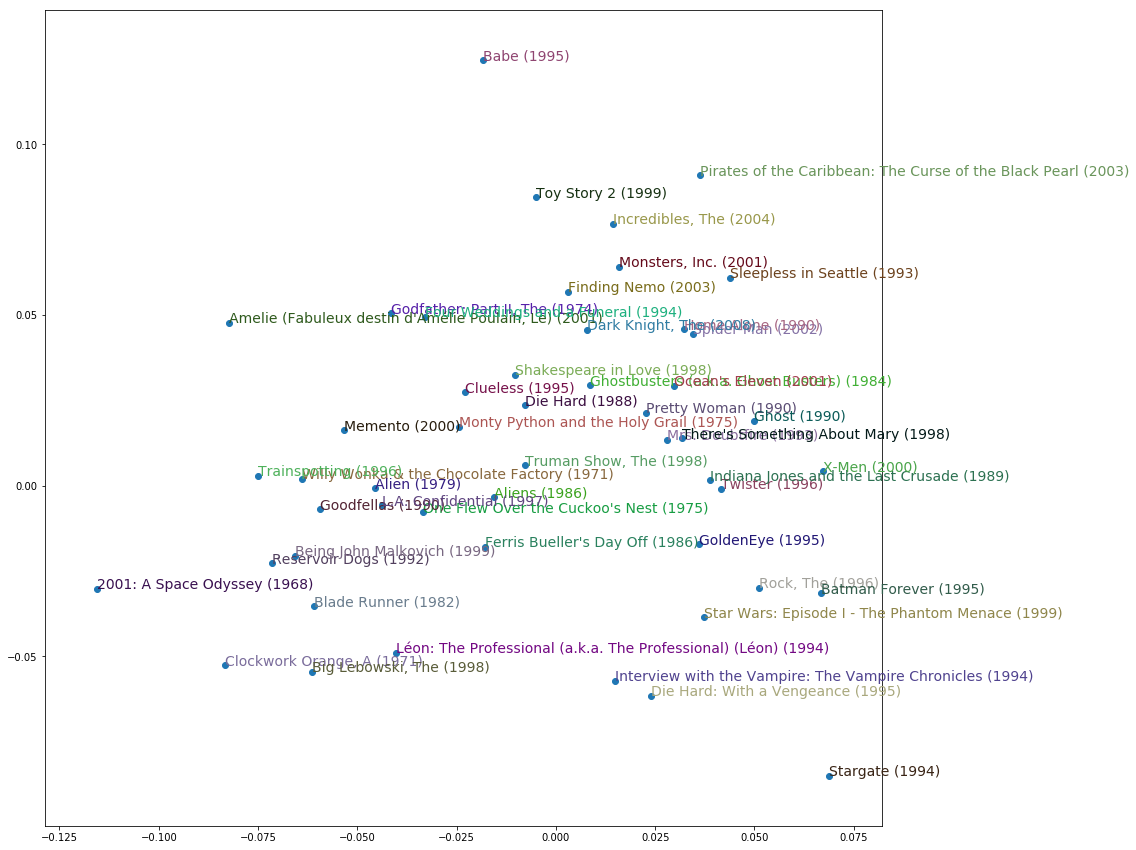

In [69]:
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
    #print (x,y,movies[i], movie_names[movies[i]])
    #plt.text(x,y,movie_names[movies[i]], color='red', fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [70]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)
print ("user_in:", type(user_in))
print ("movie_in:", type(movie_in))
print ("u:", type(u))
print ("m:", type(m))

user_in: <class 'tensorflow.python.framework.ops.Tensor'>
movie_in: <class 'tensorflow.python.framework.ops.Tensor'>
u: <class 'tensorflow.python.framework.ops.Tensor'>
m: <class 'tensorflow.python.framework.ops.Tensor'>


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
x = merge([u, m], mode='concat')
print ("x:", type(x))
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
print ("nn:", type(nn), type(nn.layers))
print ("type(nn.layers[0]:", type(nn.layers[0]))
print (nn.summary())
nn.compile(Adam(0.001), loss='mse')

x: <class 'tensorflow.python.framework.ops.Tensor'>
nn: <class 'keras.engine.training.Model'> <type 'list'>
type(nn.layers[0]: <class 'keras.engine.topology.InputLayer'>
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.


In [73]:
history6 = nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=40, 
          validation_data=([val.userId, val.movieId], val.rating))

#lesson 5 video @ 15"15' returned val_loss 0.7943

Train on 79978 samples, validate on 20026 samples
Epoch 1/40
 2048/79978 [..............................] - ETA: 6s - loss: 1.2661

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


79978/79978 [==============================] - 6s - loss: 1.2504 - val_loss: 0.8686
Epoch 2/40
79978/79978 [==============================] - 6s - loss: 1.0617 - val_loss: 0.8489
Epoch 3/40
79978/79978 [==============================] - 6s - loss: 0.9382 - val_loss: 0.8391
Epoch 4/40
79978/79978 [==============================] - 6s - loss: 0.8611 - val_loss: 0.8264
Epoch 5/40
79978/79978 [==============================] - 6s - loss: 0.8251 - val_loss: 0.8238
Epoch 6/40
79978/79978 [==============================] - 6s - loss: 0.8167 - val_loss: 0.8246
Epoch 7/40
79978/79978 [==============================] - 6s - loss: 0.8070 - val_loss: 0.8274
Epoch 8/40
79978/79978 [==============================] - 6s - loss: 0.8019 - val_loss: 0.8212
Epoch 9/40
79978/79978 [==============================] - 6s - loss: 0.8002 - val_loss: 0.8224
Epoch 10/40
79978/79978 [==============================] - 6s - loss: 0.7985 - val_loss: 0.8253
Epoch 11/40
79978/79978 [==============================] - 6

This improves on our already impressive accuracy even further!

Epoch 8/8
79907/79907 [==============================] - 13s - loss: 0.8087 - val_loss: 0.8274

after 8 epochs : loss: 0.8078 - val_loss: 0.8307
running again w 2- epochs : 